In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import GPy
import pyro
from BNN_Dropout import NN_Dropout, BNN_Dropout
from BNN_SGDHMC import BNN_SGDHMC
from BNN_SVI import BNN_SVI
from BNN_BBB import BNN_BBB


from Benchmark import RandomNN
from pybnn.bohamiann import Bohamiann

plt.rcParams['figure.figsize'] = (12.0, 8)


 /home/alaya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


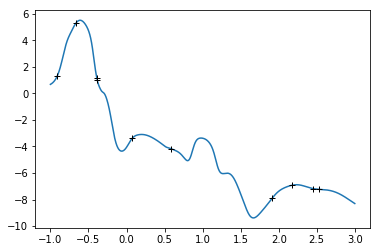

In [2]:
bench = RandomNN(1,3,50,nn.Tanh())
bench.rand_normal_weight(1)
num_plot  = 1000
num_train = 10
x = torch.linspace(-1,3,num_plot)[:,None]
y = bench(x).detach()
train_id = np.random.permutation(num_plot)[:num_train]
train_x = x[train_id]
train_y = y[train_id]
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')

In [15]:
conf = dict()
conf['num_epochs'] = 1600
conf['num_hidden'] = 50
conf['num_layers'] = 3
conf['batch_size'] = 128


conf['dropout_rate'] = 0.01
conf['lr']           = 0.01
conf['tau']          = 1.5 #0.15
conf['lscale']       = 0.25


model = BNN_Dropout(1,nn.Tanh(), conf)

conf_hmc = dict()
hmc_model = BNN_SGDHMC(dim = 1, act = nn.Tanh(), conf = conf_hmc)
kern = GPy.kern.RBF(input_dim = 1)
gp = GPy.models.GPRegression(X=train_x.numpy(), Y= train_y.detach().numpy(), kernel=kern)
gp.likelihood.variance = 1e-2

conf_svi = dict()
conf_svi['num_iters'] = 4000
conf_svi['lr'] = 1e-2
conf_svi['num_layers'] = 1
conf_svi['noise_level'] = 0.05
svi_model = BNN_SVI(dim = 1, act = nn.Tanh(), conf = conf_svi)

conf_bbb                = dict()
conf_bbb['num_epochs']  = 4000
conf_bbb['batch_size']  = 25
conf_bbb['num_layers']  = 1
conf_bbb['print_every'] = 50
conf_bbb['lr']          = 1e-1
conf_bbb['n_samples']   = 4
conf_bbb['alpha'] = 4000.
conf_bbb['beta'] = 20.
bbb_model                   = BNN_BBB(dim = 1, act = nn.Tanh(), conf = conf_bbb)

In [ ]:
bbb_model.train(train_x,train_y)
svi_model.train(train_x, train_y)
hmc_model.train(train_x, train_y)
model.train(train_x, train_y)
gp.optimize()

[Epoch    50, loss = 9481 (KL = 104.1, -log_lik = 9377)]
[Epoch   100, loss = 3529 (KL = 113.9, -log_lik = 3415)]
[Epoch   150, loss = 689.9 (KL = 85.72, -log_lik = 604.2)]
[Epoch   200, loss = 252.7 (KL = 68.78, -log_lik = 184)]
[Epoch   250, loss = 292 (KL = 55.31, -log_lik = 236.6)]
[Epoch   300, loss = 1501 (KL = 33.47, -log_lik = 1467)]
[Epoch   350, loss = 304.2 (KL = 47.44, -log_lik = 256.8)]
[Epoch   400, loss = 219.6 (KL = -38.35, -log_lik = 258)]
[Epoch   450, loss = 69.05 (KL = -75.79, -log_lik = 144.8)]
[Epoch   500, loss = 436.8 (KL = -88.36, -log_lik = 525.2)]
[Epoch   550, loss = 61.41 (KL = -99.75, -log_lik = 161.2)]
[Epoch   600, loss = 120.7 (KL = -140, -log_lik = 260.7)]
[Epoch   650, loss = 266.3 (KL = -169.7, -log_lik = 436)]
[Epoch   700, loss = -88.33 (KL = -197.5, -log_lik = 109.2)]
[Epoch   750, loss = 119.5 (KL = -213.3, -log_lik = 332.9)]
[Epoch   800, loss = -300.4 (KL = -331.2, -log_lik = 30.76)]
[Epoch   850, loss = -157.9 (KL = -309.1, -log_lik = 151.3)]


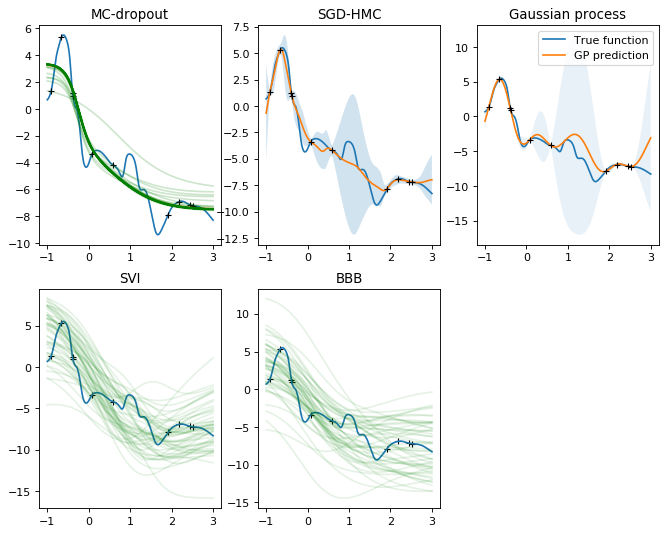

In [13]:
#py = model.predict(x)
py,pv = model.predict_mv(x)
ps = torch.sqrt(pv)
m_hmc,v_hmc = hmc_model.predict_mv(x)
m_hmc = m_hmc.detach().numpy().reshape(num_plot)
s_hmc   = v_hmc.sqrt().detach().numpy().reshape(num_plot)
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')


plt.subplot(231)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(),py.detach().numpy(),label = 'Pred')
plt.fill_between(
    x.numpy().reshape(num_plot), 
    (py - ps).reshape(num_plot).detach().numpy(), 
    (py + ps).reshape(num_plot).detach().numpy(), alpha = 0.0)
for i in range(50):
    net = model.sample()
    py  = net((x - model.x_mean) / model.x_std) * model.y_std + model.y_mean
    plt.plot(x.numpy(),py.detach().numpy(), 'g', alpha = 0.2)
plt.title('MC-dropout')

plt.subplot(232)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(x.numpy(), m_hmc)
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), m_hmc +3* s_hmc, m_hmc -3* s_hmc, alpha = 0.2)
plt.title('SGD-HMC')

plt.subplot(233)
gp_m, gp_v = gp.predict(x.numpy())
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')
plt.plot(x.numpy(), gp_m, label = 'GP prediction')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), (gp_m - 3 * np.sqrt(gp_v)).reshape(num_plot), (gp_m + 3 * np.sqrt(gp_v)).reshape(num_plot), alpha = 0.1)
plt.legend()
plt.title('Gaussian process')


plt.subplot(234)
plt.title('SVI')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')

num_samples = 50;
for i in range(50):
    r_net = svi_model.sample()
    py     = svi_model.sample_predict(r_net,x)
    plt.plot(x.numpy(), py.detach().numpy(),'g',alpha = 0.1)
    
plt.subplot(235)
plt.title('BBB')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')

num_samples = 50;
for i in range(50):
    py,_    = bbb_model.nn((x - bbb_model.x_mean) / bbb_model.x_std) 
    py       = py * bbb_model.y_std + bbb_model.y_mean
    plt.plot(x.numpy(), py.detach().numpy(),'g',alpha = 0.1)

In [13]:
xs = torch.linspace(-10,10,1000)
f = nn.Softplus()

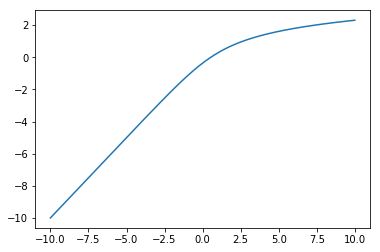

In [18]:
plt.plot(xs.numpy(), f(xs).log().detach().numpy())

In [16]:
f(xs).min()

tensor(4.5399e-05)